# DANTENIZZATORE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import notebook

In [2]:
import os
import re
import datetime
import pathlib
import json
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

from typing import Tuple
from tensorboard.plugins.hparams import api as hp

In [3]:
!pip install -q -U tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 53.2 MB/s eta 0:00:00


In [4]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 21.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 91.7 MB/s eta 0:00:00


In [5]:
import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [6]:
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

## Variabili Globali

In [7]:
# PARAMETRI GLOBALI
root_folder = 'drive/MyDrive/Progetti/Dantenizzatore/'

# DATI
data_folder_name = 'data'
train_filename = 'train_data.csv'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_data_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# PATH LOG Tensorboard
PATH_LOG = 'logs/fit'
PATH_LOG = os.path.abspath(os.path.join(root_folder, PATH_LOG))
log_dir =  os.path.abspath(os.path.join(PATH_LOG, datetime.datetime.now().strftime('%Y%m%d-%H%M%S')))
log_history = os.path.abspath(os.path.join(PATH_LOG, 'histrory.json'))

# PATH WEIGHTS Tensorboard
PATH_WEIGHTS = 'weights'
PATH_WEIGHTS = os.path.abspath(os.path.join(root_folder, PATH_WEIGHTS))
checkpoint_path = os.path.abspath(os.path.join(PATH_WEIGHTS, 'cp.ckpt'))

# VOCABOLARIO
vocab_folder = 'vocab'
multilingual_vocab_finalname = 'multilingual_vocab.txt'
dante_vocab_finalname = 'dante_vocab.txt'

VOCAB_PATH = os.path.abspath(os.path.join(root_folder, vocab_folder))
multilingual_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, multilingual_vocab_finalname))
dante_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, dante_vocab_finalname))

# parametri per il modello
ORIGINAL_COLUMN = 'Original'
TRANSLATE_COLUMN = 'Translate'
TYPE_COLUMN ='Type'

## Iper Parametri Modello

In [8]:
NUM_SAMPLES = 0  # 0 == all dataset
TEST = 200
TEST_SIZE = 0.3
BATCH_SIZE = 64

# Vocabolario e lunghezza max frase
MAX_VOCAB_SIZE = 30000
MAX_SEQ_LENGTH = 128
# Shuffle dei dati usato in preparazione del batch
BUFFER_SIZE = 2000

# Numero di layer di Decoder del Transformer
NUM_LAYERS = 3
# Numero di meccanismi di multi-head attention
NUM_HEADS = 4
# Numero di celle dei Layer Feed Forward
FF_DIM = 512
EMBEDDING_DIM = 128

# Altri iperparametri
LEARNING_RATE = 3e-4
BETA_1 = 0.66
BETA_2 = 0.999
EPSILON=1e-9
DROPUOT = 0.1

EPOCHS_DANTE = 15

debug = False
trainable = False
training = True

## Parametri BERT

In [9]:
bert_model_name = 'distilbert_multi_cased_L-6_H-768_A-12/1'
tfhub_handle_preprocess = 'https://tfhub.dev/jeongukjae/distilbert_multi_cased_preprocess/2'
tfhub_handle_encoder =  'https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1'

if debug:
  print('BERT model name                    : ', bert_model_name)
  print('BERT model selected                : ', tfhub_handle_encoder)
  print('BERT preprocess                    : ', tfhub_handle_preprocess)

## DATASET

### Caricamento Dati e Preprocessing

In [10]:
def preprocess_sentence(w):
  '''
  Preprocessing dei testi di input, impostando tutti i caratteri
  minuscoli, aggiungendo uno spazio prima di ogni punto e sostituendo
  qualsiasi carattere con uno spazio se non è compreso nel seguente elenco:
  (a-z, A-Z, ".", "?", "!", ",", "'", "’")
  '''
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r"([’]+)", "'", w)

  w = w.replace("á", "à")
  w = w.replace("é", "è")
  w = w.replace("í", "ì")
  w = w.replace("ó", "ò")
  w = w.replace("ú", "ù")
  w = w.replace('"', " ")
  w = w.replace(':', " ")
  w = w.replace('«', " ")
  w = w.replace('»', " ")
  w = w.replace('‘', " ")
  w = w.replace('-', " ")
  w = w.replace('[', " ")
  w = w.replace(']', " ")
  w = w.replace('(', " ")
  w = w.replace(')', " ")
  w = w.replace("•", " ")
  w = w.replace("..", ".")
  w = w.replace("...", ".")
  w = w.replace("\xa0", " ")
  w = w.replace("\xc3\xa8", " ")
  w = w.replace("\xe2\x80\xaf", " ")
  w = w.replace("   ", " ")
  w = w.replace("–", " ")
  w = w.replace("“", " ")
  w = w.replace("”", " ")
  w = w.replace("„", " ")
  w = w.replace("─", " ")
  w = w.replace("♪", " ")
  w = w.replace("#", " ")
  w = w.replace("/", " ")
  w = w.replace("=", " ")
  w = w.replace(">", " ")
  w = w.replace("\\", " ")
  w = w.replace("`", " ")
  w = w.replace("¡", " ")
  w = w.replace("¿", " ")
  w = w.replace("œ", " ")
  w = w.replace("♗", " ")
  w = w.replace("♘", " ")
  w = w.replace("《", " ")
  w = w.replace("》", " ")

  w = re.sub(r"(['])", r"\1 ", w)

  w = w.replace(" ' ", " '")
  w = re.sub(r'[" "]+', " ", w)

  return w

In [11]:
df = pd.read_csv(
  train_data_filenamepath,
  usecols=[ORIGINAL_COLUMN, TRANSLATE_COLUMN, TYPE_COLUMN],
)

# Preprocessing dei dati di Input
df[ORIGINAL_COLUMN] = df[ORIGINAL_COLUMN].apply(lambda x : preprocess_sentence(x))

# Preprocessing dei dati Target con aggiunta del token di fine frase
df[TRANSLATE_COLUMN] = df[TRANSLATE_COLUMN].apply(lambda x : preprocess_sentence(x))

if debug:
  print(f'Dati totali presenti nel Dataset               : {len(df)}')
  print('----------------------------------- TRAIN SET -----------------------------------------')
  print((df[ORIGINAL_COLUMN].tolist())[-1:])
  print((df[TRANSLATE_COLUMN].tolist())[-1:])
  print((df[ORIGINAL_COLUMN].tolist())[:1])
  print((df[TRANSLATE_COLUMN].tolist())[:1])

## Tokenizer

Due differenti tokenizer per la predisposizione dei dati di input:


*   EncTokenizer classe custom per la tokenizzazione dei dati di input al Layer di Encoder di Bert
*   DecTokenizer classe custom per la tokenizzazione dei dati di input al Layer di Decoder



In [12]:
input_data_vocab = df[ORIGINAL_COLUMN].tolist()
target_data_vocab = df[TRANSLATE_COLUMN].tolist()

dataset = tf.data.Dataset.from_tensor_slices((input_data_vocab, target_data_vocab))
dataset = dataset.shuffle(len(input_data_vocab)).batch(BATCH_SIZE, drop_remainder=True)

train_multilingual = dataset.map(lambda multilingual, dante: multilingual)
train_dante = dataset.map(lambda multilingual, dante: dante)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [13]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [14]:
def cleanup_text(reserved_tokens, token_txt):

  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

In [15]:
tokenizers = tf.Module()

### Classe EncTokenizer

Classe custom per la tokenizzazione dei dati di input e che crea i tre vettori necessari al layer di Encoder
Bert:


*   input_word_ids
*   input_type_ids
*   input_mask





In [16]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens = {
  'start_of_sequence_id': 101,
  'end_of_segment_id': 102,
  'padding_id': 0,
  'mask_id': 103
}

bert_vocab_args = dict(
  # The target vocabulary size
  vocab_size = MAX_VOCAB_SIZE,
  # Reserved tokens that must be included in the vocabulary
  reserved_tokens=reserved_tokens,
  # Arguments for `text.BertTokenizer`
  bert_tokenizer_params=bert_tokenizer_params,
  # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
  learn_params={},
)

In [17]:
exist_vocab = Path(multilingual_vocab_filenamepath)

if not exist_vocab.exists():
  multilingual_vocab = bert_vocab.bert_vocab_from_dataset(
      train_multilingual.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(multilingual_vocab_filenamepath, multilingual_vocab)

In [18]:
class EncTokenizer(tf.Module):
  def __init__(self, tfhub_handle_preprocess):
    self.preprocessor = hub.KerasLayer(tfhub_handle_preprocess)

  @tf.function
  def tokenize(self, strings):
    return self.preprocessor(strings)

In [19]:
tokenizers.multilingual = EncTokenizer(tfhub_handle_preprocess)

### Classe DecTokenizer

Classe custom per la tokenizzazione dei dati in lingua dantesca per il layer di Decoder


In [20]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens_vocab=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
  # The target vocabulary size
  vocab_size = MAX_VOCAB_SIZE,
  # Reserved tokens that must be included in the vocabulary
  reserved_tokens=reserved_tokens_vocab,
  # Arguments for `text.BertTokenizer`
  bert_tokenizer_params=bert_tokenizer_params,
  # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
  learn_params={},
)

In [21]:
exist_vocab = Path(dante_vocab_filenamepath)

if not exist_vocab.exists():
  dante_vocab = bert_vocab.bert_vocab_from_dataset(
      train_dante.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(dante_vocab_filenamepath, dante_vocab)

In [22]:
START = tf.argmax(tf.constant(reserved_tokens_vocab) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens_vocab) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape(out_type=tf.int32)[0]

  starts = tf.fill([count,1], START)
  starts = tf.cast(starts, tf.int32)

  ends = tf.fill([count,1], END)
  ends = tf.cast(ends, tf.int32)

  x = tf.concat([starts, ragged, ends], axis=1)
  return x

In [23]:
class DecTokenizer(tf.Module):
  def __init__(self, reserved_tokens_vocab, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True, token_out_type=tf.int32)
    self._reserved_tokens_vocab = reserved_tokens_vocab
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:

    # Include a tokenize signature for a batch of strings.
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))

    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int32))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int32))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int32))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int32))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens_vocab, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens_vocab)

In [24]:
tokenizers.dante = DecTokenizer(reserved_tokens_vocab, dante_vocab_filenamepath)

### Analisi Dati Tokenizzati

In [25]:
print(f'Vocabolario Dantesco : {tokenizers.dante.get_vocab_size()}')

Vocabolario Dantesco : 15269


## Creazione dataset
Utilizzo della libreria tf.data per la gestione del dataset da utilizzare.
Verranno creati batch di esempi che verranno utilizzati durante l'addestramento.

In [26]:
def split_dataset(df: pd.DataFrame,
                  filter_column: str,
                  debug: bool = False) -> Tuple:

  dataset = (df.loc[df[TYPE_COLUMN] == filter_column]).copy()

  if NUM_SAMPLES > 0:
    dataset = dataset[:NUM_SAMPLES]

  dataset = dataset.sample(frac = 1)
  input_data = dataset[ORIGINAL_COLUMN].tolist()
  target_data = dataset[TRANSLATE_COLUMN].tolist()

  train_input_data, validation_input_data, train_target_data, validation_target_data = train_test_split(
    input_data[:-TEST],
    target_data[:-TEST],
    test_size=TEST_SIZE,
    random_state=42,
    shuffle=True
  )

  train_input_data = train_input_data[:(int((len(train_input_data) / BATCH_SIZE)) * BATCH_SIZE)]
  train_target_data = train_target_data[:(int((len(train_target_data) / BATCH_SIZE)) * BATCH_SIZE)]

  validation_input_data = validation_input_data[:(int((len(validation_input_data) / BATCH_SIZE)) * BATCH_SIZE)]
  validation_target_data = validation_target_data[:(int((len(validation_target_data) / BATCH_SIZE)) * BATCH_SIZE)]

  test_input_data = input_data[len(train_input_data)+len(validation_input_data):]
  test_target_data = target_data[len(train_target_data)+len(validation_target_data):]

  if debug:
    print(f'Dati totali presenti nel Dataset               : {len(df)}')
    print(f'Dati totali presenti nel Dataset di Train      : {len(train_input_data)}')
    print(f'Dati totali presenti nel Dataset di Validation : {len(validation_input_data)}')
    print(f'Dati totali presenti nel Dataset di Test       : {len(test_input_data)}\n')


    print('----------------------------------- TRAIN SET -----------------------------------------')
    print(train_input_data[-4:])
    print(train_target_data[-4:])
    print('--------------------------------- VALIDATION SET --------------------------------------')
    print(validation_input_data[-4:])
    print(validation_target_data[-4:])
    print('----------------------------------- TEST SET ------------------------------------------')
    print(test_input_data[-4:])
    print(test_target_data[-4:])

    print('-------------------------------- ANALISI DATI -----------------------------------------')
    print(f'Esempi nel Dataset di Train                            : {len(train_input_data)}')
    print(f'Frase più corta nel Dataset Input di Train             : {min(train_input_data, key = len)}')
    print(f'Frase più corta nel Dataset Target di Train            : {min(train_target_data, key = len)}')
    print(f'Frase più lunga nel Dataset Input di Train             : {max(train_input_data, key = len)}')
    print(f'Frase più lunga nel Dataset Target di Train            : {max(train_target_data, key = len)}')
    print('---------------------------------------------------------------------------------------')
    print(f'Esempi nel Dataset di Validation                       : {len(validation_input_data)}')
    print(f'Frase più corta nel Dataset Input di Validation        : {min(validation_input_data, key = len)}')
    print(f'Frase più corta nel Dataset Target di Validation       : {min(validation_target_data, key = len)}')
    print(f'Frase più lunga nel Dataset Input di Validation        : {max(validation_input_data, key = len)}')
    print(f'Frase più lunga nel Dataset Target di Validation       : {max(validation_target_data, key = len)}')
    print('---------------------------------------------------------------------------------------')
    print(f'Esempi nel Dataset di Test                             : {len(test_input_data)}')
    print(f'Frase più corta nel Dataset Input di Test              : {min(test_input_data, key = len)}')
    print(f'Frase più corta nel Dataset Target di Test             : {min(test_target_data, key = len)}')
    print(f'Frase più lunga nel Dataset Input di Test              : {max(test_input_data, key = len)}')
    print(f'Frase più lunga nel Dataset Target di Test             : {max(test_target_data, key = len)}')

    print('\n--------------------------------- EXAMPLE ---------------------------------------------')
    print([min(train_input_data, key = len)])
    print(tokenizers.multilingual.tokenize([min(train_input_data, key = len)])['input_word_ids'][:, :32])
    print('------------------------------------------------------------------')
    print([min(train_target_data, key = len)])
    print(tokenizers.dante.tokenize([min(train_target_data, key = len)]))
    print('\n')
    print([max(train_input_data, key = len)])
    print(tokenizers.multilingual.tokenize([max(train_input_data, key = len)])['input_word_ids'])
    print('------------------------------------------------------------------')
    print([max(train_target_data, key = len)])
    print(tokenizers.dante.tokenize([max(train_target_data, key = len)]))

  return train_input_data, validation_input_data, test_input_data, train_target_data, validation_target_data, test_target_data

In [27]:
def prepare_batch(multilingual, dante):
  zero = tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH], tf.int32)

  # Tokenizzo l'input per l'Encoder
  encoder = tokenizers.multilingual.tokenize(multilingual)

  # Tokenizzo l'input per il Decoder e creo la variabile Target
  dante = tokenizers.dante.tokenize(dante)
  decoder = dante[:, :-1].to_tensor()
  target = dante[:, 1:].to_tensor()

  decoder = tf.concat([decoder, zero], 1)
  decoder = decoder[:, :(MAX_SEQ_LENGTH)]

  target = tf.concat([target, zero], 1)
  target = target[:, :(MAX_SEQ_LENGTH)]

  return (encoder, decoder), target

In [28]:
def make_batches(ds):
  return (
    ds
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .map(prepare_batch, tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

In [29]:
def train_val_test_dataset(df: pd.DataFrame,
                          filter_column: str,
                          debug: bool = False) -> Tuple:

  # Recupero il dataset
  train_input_data, validation_input_data, test_input_data, train_target_data, validation_target_data, test_target_data = split_dataset(df=df, filter_column=filter_column, debug=debug)

  # Definizione del dataset
  train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_target_data))
  validation_dataset = tf.data.Dataset.from_tensor_slices((validation_input_data, validation_target_data))
  test_dataset = tf.data.Dataset.from_tensor_slices((test_input_data, test_target_data))

  train_dataset = make_batches(train_dataset)
  validation_dataset = make_batches(validation_dataset)

  return train_dataset, validation_dataset, test_dataset

In [30]:
train_dataset_dante, validation_dataset_dante, test_dataset = train_val_test_dataset(df=df,
                                                                                     filter_column='DANTE',
                                                                                     debug=debug)

In [31]:
# Recupero un batch di esempi per la verifica delle classi custom che andrò a creare
for (enc_input, dec_input), target in train_dataset_dante.take(1):
  print('----------------------- ENCODER  -------------------------------')
  print(f'Shape                    : {enc_input}')
  print(f'Shape                    : {enc_input["input_word_ids"].shape}')
  print(f'Word Ids                 : {enc_input["input_word_ids"][0, :12]}')
  print(f'Input Mask               : {enc_input["input_mask"][0, :12]}')
  print('--------------------- DECODER ----------------------------------')
  print(f'Shape it input           : {dec_input.shape}')
  print(f'Example it input         : {dec_input[0][:12]}')
  print('--------------------- TARGET -----------------------------------')
  print(f'Shape it input           : {target.shape}')
  print(f'Example it target        : {target[0][:12]}')

----------------------- ENCODER  -------------------------------
Shape                    : {'input_mask': <tf.Tensor: shape=(64, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'input_word_ids': <tf.Tensor: shape=(64, 128), dtype=int32, numpy=
array([[  101, 27113,   171, ...,     0,     0,     0],
       [  101, 22800, 11167, ...,     0,     0,     0],
       [  101, 11589, 12714, ...,     0,     0,     0],
       ...,
       [  101, 12882, 10105, ...,     0,     0,     0],
       [  101, 10235, 51354, ...,     0,     0,     0],
       [  101, 52250,   117, ...,     0,     0,     0]], dtype=int32)>}
Shape                    : (64, 128)
Word Ids                 : [  101 27113   171   112 10176 10141 14989 10322 20859 10355 10647 27830]
Input Mask               : [1 1 1 1 1 1 1 1 1 1 1 1]
--

## Encoder BERT

Predispondo la classe necessaria per la costruzione di BERT


In [32]:
class EncoderBert(tf.keras.layers.Layer):
  def __init__(self, bert_encoder, name='EncoderBert', trainable=False):
    super(EncoderBert, self).__init__()

    self.encoder = hub.KerasLayer(bert_encoder, name='BERT_encoder', trainable=trainable)

  def call(self, x, debug=False):

    if debug:
      print(f'****************** DEBUG ENCODER BERT ******************')
      print(f"First example")
      print(f'Keys                         : {list(x.keys())}')
      print(f'Shape                        : {x["input_word_ids"].shape}')
      print(f'Word Ids                     : {x["input_word_ids"][0, :16]}')
      print(f'Input Mask                   : {x["input_mask"][0, :16]}')

    x = self.encoder(x)['sequence_output']

    if debug:
      print()
      print(f'Encoder Outputs BERT Shape   : {x.shape}')
      print(f'Encoder Outputs BERT Values  : {x[0, :1, :16]}')
      print('*********************************************************')

    return x

In [33]:
encoder_bert = EncoderBert(bert_encoder=tfhub_handle_encoder,
                           trainable=trainable)

bert_outputs = encoder_bert(enc_input, debug)

## Decoder

Predispondo la classe necessaria per la costruzione di un Layer di Decoder

### TOKEN AND POSITION EMBEDDING

Implementazione del blocco Embedding per l'utilizzo di vettori posizionali insieme ai vettori di token di parole tramite estensione della classe Layer di Keras.

In [34]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.maxlen = maxlen
    self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, name='Token_Embedding')
    self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim, name='Positional_Embedding')

  def call(self, x, debug=False):
    x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen, padding='post')
    maxlen = tf.shape(x)[-1]

    if debug:
      print('********** DEBUG TOKEN AND POSITION EMBEDDING ***********')
      print(f'Sequence Max len                          : {maxlen}')
      print(f'Sequence Shape                            : {tf.shape(x)}')

    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    output = x + positions

    if debug:
      print(f'Shape TokenAndPositionEmbedding           : {output.shape}')
      print('*********************************************************')

    return output

In [35]:
token_position_dante = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.dante.get_vocab_size(), EMBEDDING_DIM)

inputs_decoder = token_position_dante(dec_input, debug)

### LAYER DECODER

Implementazione di un blocco di DecoderTransformer tramite estensione della classe Layer di Keras

In [36]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, rate=0.5, name='DECODER', num_layers_name=1):
    super(Decoder, self).__init__()
    self.att1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name='Decoder_MultiHeadAttention_input_decoder_Block_'+str(num_layers_name))
    self.att2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name='Decoder_MultiHeadAttention_output_encoder_Block_'+str(num_layers_name))
    self.ffn = tf.keras.Sequential(
      [
       tf.keras.layers.Dense(ff_dim, activation='relu', name='Decoder_FFN_Dense_1_Block_'+str(num_layers_name)),
       tf.keras.layers.Dense(embed_dim, name='Decoder_FFN_Dense_2_Block_'+str(num_layers_name)),
      ]
    )
    self.layernorm1 = tf.keras.layers.LayerNormalization(name='Decoder_LayerNormalization_1_Block_'+str(num_layers_name))
    self.layernorm2 = tf.keras.layers.LayerNormalization(name='Decoder_LayerNormalization_2_Block_'+str(num_layers_name))
    self.layernorm3 = tf.keras.layers.LayerNormalization(name='Decoder_LayerNormalization_3_Block_'+str(num_layers_name))
    self.dropout1 = tf.keras.layers.Dropout(rate, name='Decoder_Dropout_1_Block_'+str(num_layers_name))
    self.dropout2 = tf.keras.layers.Dropout(rate, name='Decoder_Dropout_2_Block_'+str(num_layers_name))
    self.dropout3 = tf.keras.layers.Dropout(rate, name='Decoder_Dropout_3_Block_'+str(num_layers_name))

    self._name = name

  def call(self, inputs, bert_outputs, training=False, debug=False):
    attn_output1 = self.att1(query=inputs,
                             value=inputs,
                             key=inputs,
                             use_causal_mask=True)

    attn_output1 = self.dropout1(attn_output1)
    out1 = self.layernorm1(inputs + attn_output1)

    attn_output2 = self.att2(key=bert_outputs,
                             value=bert_outputs,
                             query=out1)

    attn_output2 = self.dropout2(attn_output2, training=training)
    out2 = self.layernorm2(out1 + attn_output2)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)

    output = self.layernorm3(out2 + ffn_output)

    if debug:
      print('******************* DEBUG DECODER ***********************')
      print(f'Input Shape                       : {inputs.shape}')
      print(f'Shape Outputs Decoder             : {output.shape}')
      print('*********************************************************')

    return output

In [37]:
decoder = Decoder(EMBEDDING_DIM,
                  NUM_HEADS,
                  FF_DIM,
                  DROPUOT)

outputs_decoder = decoder(inputs=inputs_decoder,
                          bert_outputs=bert_outputs,
                          training=training,
                          debug=debug)

## TRANSFORMER

Implementazione del blocco Transformer tramite estensione della classe Layer di Keras.

In [38]:
class TransformerBlock(tf.keras.Model):
  def __init__(self,
               num_layers,
               embed_dim,
               num_heads,
               ff_dim,
               max_len,
               vocab_size,
               tfhub_handle_encoder,
               trainable,
               rate=0.5):

    super(TransformerBlock, self).__init__()

    self.num_layers = num_layers

    self.token_pos_dec = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)

    self.encoder = EncoderBert(tfhub_handle_encoder, trainable=trainable)
    self.decoder = [Decoder(embed_dim, num_heads, ff_dim, rate, num_layers_name=i+1) for i in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate, name='Transformer_Dropout_Pre_Final_Layer')
    self.final_layer = tf.keras.layers.Dense(vocab_size, name='Transformer_Final_Layer')

  def call(self, inputs, training=False, debug=False):
    inputs_encoder, inputs_decoder  = inputs

    encoder_output = self.encoder(inputs_encoder, debug=debug)

    inputs_decoder = self.token_pos_dec(inputs_decoder, debug)

    if debug:
      print(f'---------------- DEBUG TRANSFORMER BLOCK ----------------')
      print(f'inputs_encoder       : {inputs_encoder["input_word_ids"].shape}')
      print(f'inputs_decoder       : {inputs_decoder.shape}')

    transformer_output = inputs_decoder

    for i in range(self.num_layers):
      transformer_output = self.decoder[i](inputs=transformer_output,
                                           bert_outputs=encoder_output,
                                           training=training,
                                           debug=debug)

    transformer_output = self.dropout(transformer_output)
    transformer_output = self.final_layer(transformer_output)

    if debug:
      print(f'Output Shape       : {transformer_output.shape}')
      print(f'Output Transformer : {transformer_output[0, :1, :12]}')
      print(f'---------------------------------------------------------')

    return transformer_output

In [39]:
transformer = TransformerBlock(NUM_LAYERS,
                               EMBEDDING_DIM,
                               NUM_HEADS,
                               FF_DIM,
                               MAX_SEQ_LENGTH,
                               tokenizers.dante.get_vocab_size(),
                               tfhub_handle_encoder,
                               trainable,
                               DROPUOT)

transformer_output = transformer((enc_input, dec_input),
                                 training=training,
                                 debug=debug)

In [40]:
transformer.summary()

Model: "transformer_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  multiple                 1970816   
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 encoder_bert_1 (EncoderBert  multiple                 134734080 
 )                                                               
                                                                 
 DECODER (Decoder)           multiple                  1315456   
                                                                 
 DECODER (Decoder)           multiple                  1315456   
                                                                 
 DECODER (Decoder)           multiple                  1315456   
                                                 

## Addestramento Modello

### Callbacks

In [41]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

# Create a callback Tensorboard
log_dir =  os.path.abspath(os.path.join(PATH_LOG, 'dantenizzatore'))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

# Create a callback save the log history
json_logging_callback = tf.keras.callbacks.LambdaCallback(
  on_epoch_end=lambda epoch, logs: json_log.write(
    json.dumps({'epoch': epoch,
                'loss': logs['loss'],
                'masked_accuracy': logs['masked_accuracy'],
                'val_loss': logs['val_loss'],
                'val_masked_accuracy': logs['val_masked_accuracy']}) + '\n'),
  on_train_end=lambda logs: json_log.close()
)

### Compilazione

In [42]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

In [43]:
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [44]:
transformer.compile(
  loss=masked_loss,
  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,
                                     beta_1=BETA_1,
                                     beta_2=BETA_2,
                                     epsilon=EPSILON),
  metrics=[masked_accuracy])

### Train

In [45]:
start = datetime.datetime.now()

json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

transformer.fit(train_dataset_dante,
                initial_epoch=0,
                epochs=EPOCHS_DANTE,
                shuffle=True,
                validation_data=validation_dataset_dante,
                callbacks=[tensorboard_callback,
                           json_logging_callback,
                           cp_callback
                           ])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 1/15
1476/1476 [==============================] - 823s 554ms/step - loss: 5.1422 - masked_accuracy: 0.2542 - val_loss: 4.0525 - val_masked_accuracy: 0.3390
Epoch 2/15
1476/1476 [==============================] - 820s 556ms/step - loss: 3.4045 - masked_accuracy: 0.4076 - val_loss: 2.6808 - val_masked_accuracy: 0.4932
Epoch 3/15
1476/1476 [==============================] - 821s 556ms/step - loss: 2.2036 - masked_accuracy: 0.5668 - val_loss: 1.6079 - val_masked_accuracy: 0.6718
Epoch 4/15
1476/1476 [==============================] - 822s 557ms/step - loss: 1.3947 - masked_accuracy: 0.7056 - val_loss: 1.0013 - val_masked_accuracy: 0.7881
Epoch 5/15
1476/1476 [==============================] - 819s 555ms/step - loss: 0.9731 - masked_accuracy: 0.7835 - val_loss: 0.6982 - val_masked_accuracy: 0.8464
Epoch 6/15
1476/1476 [==============================] - 819s 555ms/step - loss: 0.7561 - masked_accuracy: 0.8247 - val_loss: 0.5481 - val_masked_accuracy: 0.8748
Epoch 7/15
1476/1476 [======

In [45]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

transformer.compile(
  loss=masked_loss,
  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,
                                     beta_1=BETA_1,
                                     beta_2=BETA_2,
                                     epsilon=EPSILON),
  metrics=[masked_accuracy])

In [46]:
start = datetime.datetime.now()

json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

transformer.fit(train_dataset_dante,
                initial_epoch=EPOCHS_DANTE,
                epochs=EPOCHS_DANTE+EPOCHS_DANTE,
                shuffle=True,
                validation_data=validation_dataset_dante,
                callbacks=[tensorboard_callback,
                           json_logging_callback,
                           cp_callback
                           ])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 16/30
1476/1476 [==============================] - 824s 555ms/step - loss: 0.3538 - masked_accuracy: 0.9073 - val_loss: 0.2183 - val_masked_accuracy: 0.9442
Epoch 17/30
1476/1476 [==============================] - 821s 556ms/step - loss: 0.3303 - masked_accuracy: 0.9124 - val_loss: 0.2196 - val_masked_accuracy: 0.9432
Epoch 18/30
1476/1476 [==============================] - 823s 558ms/step - loss: 0.3155 - masked_accuracy: 0.9159 - val_loss: 0.2134 - val_masked_accuracy: 0.9446
Epoch 19/30
1476/1476 [==============================] - 824s 558ms/step - loss: 0.3016 - masked_accuracy: 0.9188 - val_loss: 0.2082 - val_masked_accuracy: 0.9458
Epoch 20/30
1476/1476 [==============================] - 823s 558ms/step - loss: 0.2900 - masked_accuracy: 0.9214 - val_loss: 0.2084 - val_masked_accuracy: 0.9456
Epoch 21/30
1476/1476 [==============================] - 825s 559ms/step - loss: 0.2787 - masked_accuracy: 0.9241 - val_loss: 0.2040 - val_masked_accuracy: 0.9468
Epoch 22/30
1476/1476 

## Valutazione dell'addestramento
Avendo in output il log ed i risultati dell'addestramento, possiamo visualizzare
queste informazioni relativamente alle metriche di interesse.

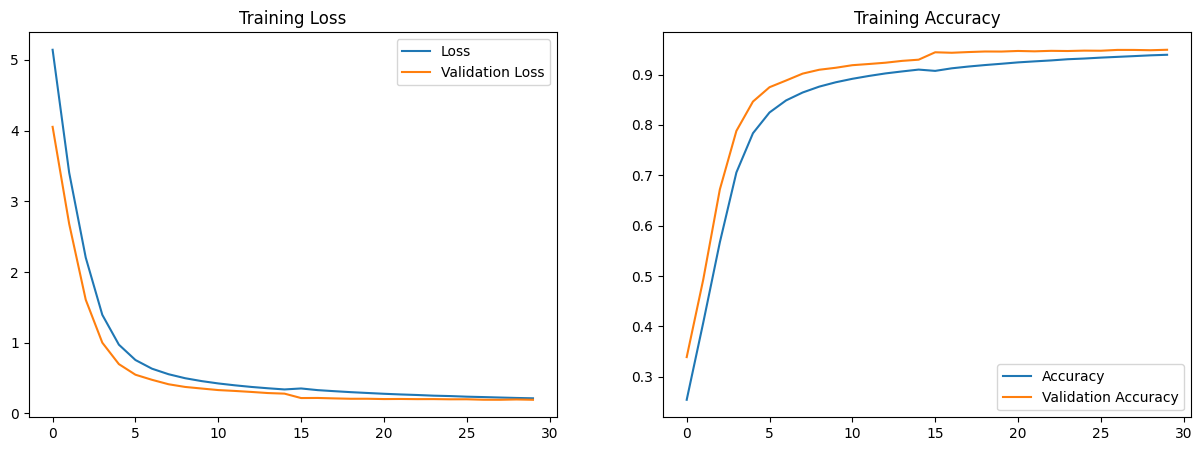

In [47]:
df_history = pd.read_json(log_history, lines=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(df_history['loss'], label='Loss')
ax1.plot(df_history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

ax2.plot(df_history['masked_accuracy'], label='Accuracy')
ax2.plot(df_history['val_masked_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

## Test del modello
La seguente cella permette di caricare l'ultimo checkpoint dell'addestramento
precedentemente salvato.

In [45]:
trainable = False

transformer = TransformerBlock(NUM_LAYERS,
                               EMBEDDING_DIM,
                               NUM_HEADS,
                               FF_DIM,
                               MAX_SEQ_LENGTH,
                               tokenizers.dante.get_vocab_size(),
                               tfhub_handle_encoder,
                               trainable,
                               DROPUOT)

In [46]:
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [49]:
class Translate:
  def __init__(self, transformer_block, tokenizers):
    self.transformer = transformer_block
    self.tokenizers = tokenizers

  def predict(self, input_text, max_length):
    if input_text is None:
      input_text = (df[ORIGINAL_COLUMN].tolist())[np.random.choice(len(df[ORIGINAL_COLUMN].tolist()))]
      print(input_text)

    inputs_bert = self.tokenizers.multilingual.tokenize(input_text)

    start_end = self.tokenizers.dante.tokenize([''])[0]
    start = (start_end[0][tf.newaxis]).numpy()[0]
    end = (start_end[1][tf.newaxis]).numpy()[0]

    output_array = tf.TensorArray(dtype=tf.int32, size=max_length, dynamic_size=True)
    output_array = output_array.write(0, tf.constant([start]))

    out_words = []

    for i in tf.range(max_length):
      # decodifica e recupero probabilità di output
      output = tf.transpose(output_array.stack())

      transformer_output = transformer((inputs_bert, output),
                                        training=False,
                                        debug=False)

      predictions = transformer_output[:, -1:, :]

      # selezione della parola più probabile
      predict = tf.argmax(predictions, -1)
      pred_values = (tf.keras.backend.argmax(transformer_output, axis=-1)).numpy()

      # inserimento della parola nella sequenza di output
      output_array = output_array.write(i+1, [pred_values[0][i]])

      if pred_values[0][i] == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.dante.detokenize(output)[0]
    tokens = tokenizers.dante.lookup(output)[0]

    return text, tokens

In [50]:
translate = Translate(transformer_block=transformer,
                      tokenizers=tokenizers)

# Recupero un batch di esempi per la verifica delle classi custom che andrò a creare
for test_input_data, test_target_data in test_dataset.take(50):
  test_input_data = test_input_data.numpy().decode()
  test_target_data = test_target_data.numpy().decode()

  text, token = translate.predict(tf.constant([test_input_data]), MAX_SEQ_LENGTH)

  print(f'{"Input":15s}: {test_input_data}')
  print(f'{"Target":15s}: {test_target_data}')
  print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')
  print('---------------------------------------------')

Input          : offrar sitt liv för att uppnå dyrbar frihet
Target         :  libertà va cercando , ch' è sì cara , come sa chi per lei vita rifiuta
Prediction     : liberta va cercando , ch ' e si cara , come sa chi per lei vita rifiuta
---------------------------------------------
Input          :  När jag såg på honom , såg han på mig i tur och ordning och öppnade sitt bröst med händerna och sade Se nu hur jag är sliten . 
Target         :  Mentre che tutto in lui veder m' attacco , guardommi e con le man s' aperse il petto , dicendo Or vedi com' io mi dilacco
Prediction     : si mi vedea se ben , o detto mi contenti per veder le poste , ed insieme braccia sana e vince con sospiri
---------------------------------------------
Input          :  von Flügeln Als der Verfluchte zu Ende gesprochen hatte , ging die Flamme wund , winkte und wackelte die spitzen Spitzen seiner Flügel . 
Target         :  Quand' elli ebbe 'l suo dir così compiuto , la fiamma dolorando si partio , torcendo e

In [51]:
text_input_data = 'è bello divertirsi con gli amici'

text, token = translate.predict(tf.constant([text_input_data]), MAX_SEQ_LENGTH)
print(f'{"Input":15s}: {text_input_data}')
print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')
print('---------------------------------------------')

Input          : è bello divertirsi con gli amici
Prediction     : convien ch ' i ' agia , ch ' i ' non sia perduto .
---------------------------------------------


In [52]:
text_input_data = 'cocacola al bar'

text, token = translate.predict(tf.constant([text_input_data]), MAX_SEQ_LENGTH)
print(f'{"Input":15s}: {text_input_data}')
print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')
print('---------------------------------------------')

Input          : cocacola al bar
Prediction     : e ' l savio duca
---------------------------------------------


In [53]:
text_input_data = 'sono andato al supermercato a comprare una birra'

text, token = translate.predict(tf.constant([text_input_data]), MAX_SEQ_LENGTH)
print(f'{"Input":15s}: {text_input_data}')
print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')
print('---------------------------------------------')

Input          : sono andato al supermercato a comprare una birra
Prediction     : si faciev ' ella que ' di su ' ostello ;
---------------------------------------------


In [54]:
text_input_data = 'quanta è figa la masterclass di Datamasters'

text, token = translate.predict(tf.constant([text_input_data]), MAX_SEQ_LENGTH)
print(f'{"Input":15s}: {text_input_data}')
print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')
print('---------------------------------------------')

Input          : quanta è figa la masterclass di Datamasters
Prediction     : che quella e del suo si guarda in caccia ,
---------------------------------------------


## Tensorboard

In [57]:
!tensorboard dev upload --logdir drive/MyDrive/Progetti/Dantenizzatore/logs/fit/dantenizzatore/ \
  --name "Simple experiment with DANTE" \
  --description "Training results" \
  --one_shot

2023-07-02 12:40:04.904540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/6TNvnLzjSnqOm1rdGzWJOA/

[2023-07-02T12:40:07] Started scanning logdir.
[2023-07-02T12:40:15] Total uploaded: 180 scalars, 5460 tensors (3.8 MB), 0 binary objects
[2023-07-02T12:40:15] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/6TNvnLzjSnqOm1rdGzWJOA/
